# Environment

In [16]:
!git clone https://github.com/cuongtv312/marl-delivery.git marl_delivery

fatal: destination path 'marl_delivery' already exists and is not an empty directory.


In [17]:
from marl_delivery.env import Environment
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.distributions import Categorical
import numpy as np
import random
import os
from sklearn.calibration import LabelEncoder # For action conversion
import matplotlib.pyplot as plt

SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Convert Observation - Spatial Features

In [18]:
def convert_observation(env_state_dict, persistent_packages_for_env, current_robot_idx):
    """
    Tạo observation dạng multi-channel cho 1 robot.
    Channels:
        0: Obstacle map
        1: Vị trí robot hiện tại
        2: Vị trí các robot khác
        3: Vị trí start của các package 'waiting'
        4: Vị trí target của các package 'active' (waiting hoặc in_transit)
        5: Vị trí target của package mà robot này đang cầm (nếu có)
    """
    num_channels = 6
    grid = np.array(env_state_dict['map'], dtype=np.float32)
    n_rows, n_cols = grid.shape
    obs = np.zeros((num_channels, n_rows, n_cols), dtype=np.float32)

    # Channel 0: Obstacle map
    obs[0] = grid

    # Kiểm tra robot index hợp lệ
    if not (0 <= current_robot_idx < len(env_state_dict['robots'])):
        return obs

    robots = env_state_dict['robots']
    my_r, my_c, my_pkg = [int(x) for x in robots[current_robot_idx]]
    my_r -= 1; my_c -= 1  # 0-indexed

    # Channel 1: Vị trí robot hiện tại
    if 0 <= my_r < n_rows and 0 <= my_c < n_cols:
        obs[1, my_r, my_c] = 1.0

    # Channel 2: Vị trí các robot khác
    for i, (r, c, _) in enumerate(robots):
        if i == current_robot_idx: continue
        r, c = int(r)-1, int(c)-1
        if 0 <= r < n_rows and 0 <= c < n_cols:
            obs[2, r, c] = 1.0

    # Channel 3, 4, 5: Package info
    t = env_state_dict['time_step']
    for pkg_id, pkg in persistent_packages_for_env.items():
        # Channel 3: Start pos của package 'waiting'
        if pkg['status'] == 'waiting' and pkg['start_time'] <= t:
            sr, sc = pkg['start_pos']
            if 0 <= sr < n_rows and 0 <= sc < n_cols:
                obs[3, sr, sc] = 1.0
        # Channel 4: Target pos của package 'active'
        if (pkg['status'] == 'waiting' and pkg['start_time'] <= t) or pkg['status'] == 'in_transit':
            tr, tc = pkg['target_pos']
            if 0 <= tr < n_rows and 0 <= tc < n_cols:
                obs[4, tr, tc] = 1.0

    # Channel 5: Target pos của package mà robot này đang cầm
    if my_pkg != 0 and my_pkg in persistent_packages_for_env:
        pkg = persistent_packages_for_env[my_pkg]
        if pkg['status'] == 'in_transit':
            tr, tc = pkg['target_pos']
            if 0 <= tr < n_rows and 0 <= tc < n_cols:
                obs[5, tr, tc] = 1.0

    return obs

# Generate Vector Features - Non Spatial Features

In [19]:
def generate_vector_features(env_state_dict, persistent_packages_for_env, current_robot_idx,
                            max_time_steps,
                            max_other_robots_to_observe, max_packages_to_observe):
    """
    Sinh vector đặc trưng phi không gian cho 1 robot.
    """
    n_rows, n_cols = np.array(env_state_dict['map'], dtype=np.float32).shape
    robots = env_state_dict['robots']
    t = env_state_dict['time_step']

    # Định nghĩa số chiều cho từng phần
    my_feat = 6
    other_feat = 5
    pkg_feat = 5
    time_feat = 1

    # Nếu robot index không hợp lệ, trả về vector 0
    total_len = my_feat + max_other_robots_to_observe * other_feat + max_packages_to_observe * pkg_feat + time_feat
    if not (0 <= current_robot_idx < len(robots)):
        return np.zeros(total_len, dtype=np.float32)

    # 1. Thông tin robot hiện tại
    my_r, my_c, my_pkg = [int(x) for x in robots[current_robot_idx]]
    my_r -= 1; my_c -= 1
    is_carrying = 1.0 if my_pkg != 0 else 0.0
    feat = [
        my_r / n_rows,
        my_c / n_cols,
        is_carrying
    ]
    # Nếu đang cầm package
    if is_carrying and my_pkg in persistent_packages_for_env:
        pkg = persistent_packages_for_env[my_pkg]
        if pkg['status'] == 'in_transit':
            tr, tc = pkg['target_pos']
            deadline = pkg['deadline']
            feat += [
                (tr - my_r) / n_rows,
                (tc - my_c) / n_cols,
                max(0, deadline - t) / max_time_steps if max_time_steps > 0 else 0.0
            ]
        else:
            feat += [0.0, 0.0, 0.0]
    else:
        feat += [0.0, 0.0, 0.0]

    # 2. Thông tin các robot khác
    others = []
    for i, (r, c, pkg_id) in enumerate(robots):
        if i == current_robot_idx: continue
        r, c, pkg_id = int(r)-1, int(c)-1, int(pkg_id)
        is_c = 1.0 if pkg_id != 0 else 0.0
        other = [
            (r - my_r) / n_rows,
            (c - my_c) / n_cols,
            is_c
        ]
        if is_c and pkg_id in persistent_packages_for_env:
            pkg = persistent_packages_for_env[pkg_id]
            if pkg['status'] == 'in_transit':
                tr, tc = pkg['target_pos']
                other += [
                    (tr - r) / n_rows,
                    (tc - c) / n_cols
                ]
            else:
                other += [0.0, 0.0]
        else:
            other += [0.0, 0.0]
        others.append(other)
    # Sắp xếp theo khoảng cách tới robot hiện tại
    others.sort(key=lambda x: x[0]**2 + x[1]**2)
    for i in range(max_other_robots_to_observe):
        feat += others[i] if i < len(others) else [0.0]*other_feat

    # 3. Thông tin các package 'waiting'
    pkgs = []
    for pkg_id, pkg in persistent_packages_for_env.items():
        if pkg['status'] == 'waiting' and pkg['start_time'] <= t:
            sr, sc = pkg['start_pos']
            tr, tc = pkg['target_pos']
            deadline = pkg['deadline']
            pkgs.append([
                (sr - my_r) / n_rows,
                (sc - my_c) / n_cols,
                (tr - my_r) / n_rows,
                (tc - my_c) / n_cols,
                max(0, deadline - t) / max_time_steps if max_time_steps > 0 else 0.0
            ])
    # Sắp xếp theo deadline và khoảng cách
    pkgs.sort(key=lambda x: (x[4], x[0]**2 + x[1]**2))
    for i in range(max_packages_to_observe):
        feat += pkgs[i] if i < len(pkgs) else [0.0]*pkg_feat

    # 4. Thời gian toàn cục (chuẩn hóa)
    feat.append(t / max_time_steps if max_time_steps > 0 else 0.0)

    return np.array(feat, dtype=np.float32)

# Convert Global State

In [20]:
def convert_global_state(env_state_dict, persistent_packages_for_env,
                                max_time_steps,
                                max_robots_in_state=100, max_packages_in_state=100):
    """
    Sinh global state (spatial + vector) cho Critic.
    """
    # --- Spatial ---
    num_map_channels = 4
    n_rows, n_cols = np.array(env_state_dict['map'], dtype=np.float32).shape

    global_map = np.zeros((num_map_channels, n_rows, n_cols), dtype=np.float32)
    global_map[0] = np.array(env_state_dict['map'], dtype=np.float32)  # Obstacles

    # Channel 1: All robot positions
    for r, c, _ in env_state_dict['robots']:
        r0, c0 = int(r)-1, int(c)-1
        if 0 <= r0 < n_rows and 0 <= c0 < n_cols:
            global_map[1, r0, c0] = 1.0

    t = env_state_dict['time_step']
    for pkg in persistent_packages_for_env.values():
        # Channel 2: waiting package start
        if pkg['status'] == 'waiting' and pkg['start_time'] <= t:
            sr, sc = pkg['start_pos']
            if 0 <= sr < n_rows and 0 <= sc < n_cols:
                global_map[2, sr, sc] = 1.0
        # Channel 3: active package target
        if (pkg['status'] == 'waiting' and pkg['start_time'] <= t) or pkg['status'] == 'in_transit':
            tr, tc = pkg['target_pos']
            if 0 <= tr < n_rows and 0 <= tc < n_cols:
                global_map[3, tr, tc] = 1.0

    # --- Vector ---
    vec = []
    # 1. Robots (padded)
    for i in range(max_robots_in_state):
        if i < len(env_state_dict['robots']):
            r, c, carried = env_state_dict['robots'][i]
            r0, c0 = int(r)-1, int(c)-1
            is_carrying = 1.0 if carried != 0 else 0.0
            vec += [r0/n_rows, c0/n_cols, is_carrying]
            if is_carrying and carried in persistent_packages_for_env:
                pkg = persistent_packages_for_env[carried]
                if pkg['status'] == 'in_transit':
                    tr, tc = pkg['target_pos']
                    deadline = pkg['deadline']
                    vec += [tr/n_rows, tc/n_cols, max(0, deadline-t)/max_time_steps if max_time_steps > 0 else 0.0]
                else:
                    vec += [0.0, 0.0, 0.0]
            else:
                vec += [0.0, 0.0, 0.0]
        else:
            vec += [0.0]*6

    # 2. Active packages (padded)
    pkgs = []
    for pkg in persistent_packages_for_env.values():
        is_active = (pkg['status'] == 'waiting' and pkg['start_time'] <= t) or pkg['status'] == 'in_transit'
        if is_active:
            pkgs.append(pkg)
    pkgs = sorted(pkgs, key=lambda p: p['id'])
    for i in range(max_packages_in_state):
        if i < len(pkgs):
            pkg = pkgs[i]
            sr, sc = pkg['start_pos']
            tr, tc = pkg['target_pos']
            deadline = pkg['deadline']
            status = pkg['status']
            # start pos (nếu waiting), target pos, deadline, status, carrier_id_norm
            if status == 'waiting':
                vec += [sr/n_rows, sc/n_cols]
            else:
                vec += [0.0, 0.0]
            vec += [tr/n_rows, tc/n_cols]
            vec += [max(0, deadline-t)/max_time_steps if max_time_steps > 0 else 0.0]
            vec += [0.0 if status == 'waiting' else 1.0]
            carrier_id_norm = -1.0
            if status == 'in_transit':
                for ridx, rdata in enumerate(env_state_dict['robots']):
                    if rdata[2] == pkg['id']:
                        carrier_id_norm = ridx/(max_robots_in_state-1) if max_robots_in_state > 1 else 0.0
                        break
            vec += [carrier_id_norm]
        else:
            vec += [0.0]*7

    # 3. Global time
    vec.append(t/max_time_steps if max_time_steps > 0 else 0.0)
    return global_map, np.array(vec, dtype=np.float32)

# Visualize Features

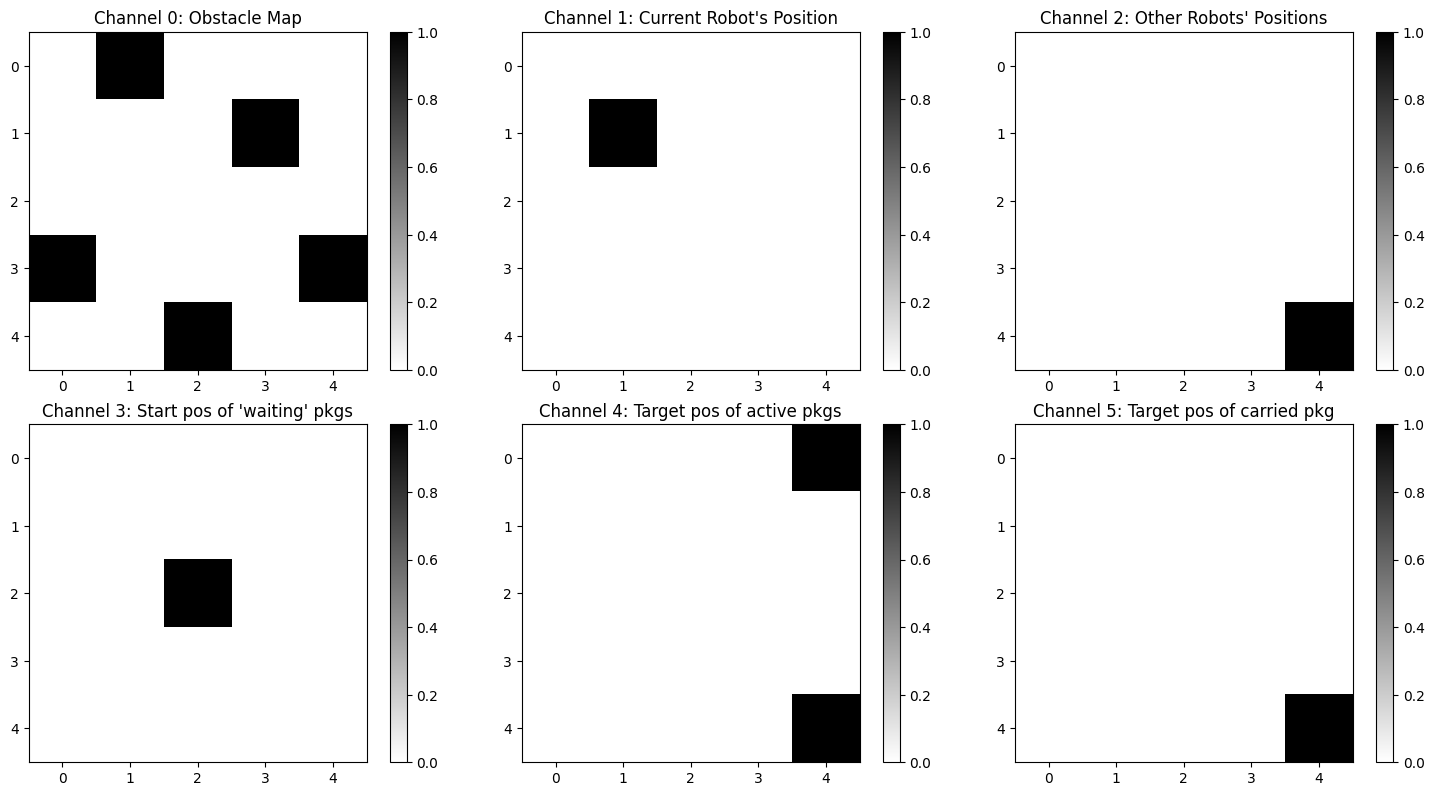

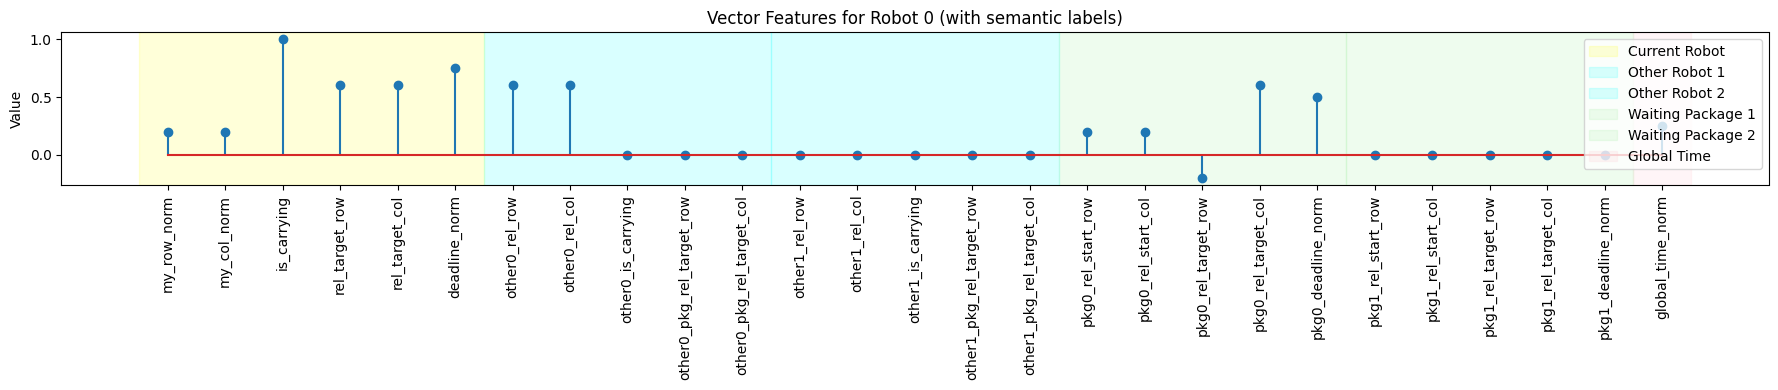

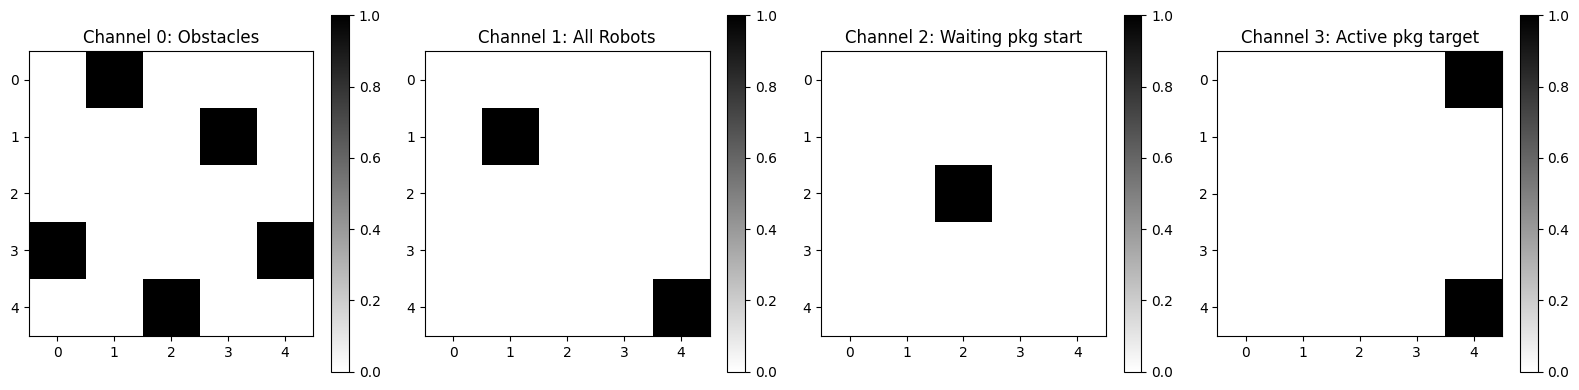

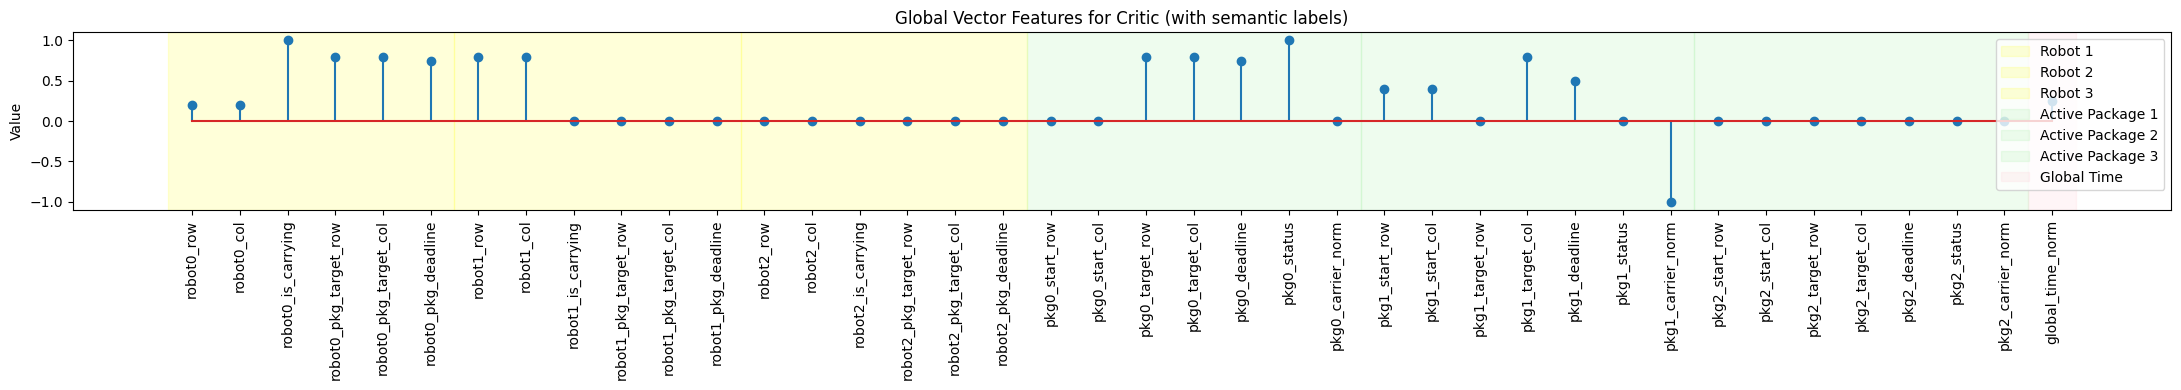

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Dummy env_state_dict và persistent_packages_for_env
env_state_dict = {
    'map': np.array([
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1],
        [0, 0, 1, 0, 0]
    ], dtype=np.float32),
    'robots': [
        (2, 2, 1),  # Robot 0 at (1,1), carrying package 1 (all 1-indexed)
        (5, 5, 0),  # Robot 1 at (4,4), not carrying
    ],
    'time_step': 5
}
persistent_packages_for_env = {
    1: {
        'id': 1,
        'start_pos': (0, 0),      # 0-indexed
        'target_pos': (4, 4),     # 0-indexed
        'start_time': 0,
        'deadline': 20,
        'status': 'in_transit'
    },
    2: {
        'id': 2,
        'start_pos': (2, 2),
        'target_pos': (0, 4),
        'start_time': 3,
        'deadline': 15,
        'status': 'waiting'
    }
}

# --- 1. Visualize convert_observation ---
obs = convert_observation(env_state_dict, persistent_packages_for_env, current_robot_idx=0)
channel_names = [
    "Obstacle Map",
    "Current Robot's Position",
    "Other Robots' Positions",
    "Start pos of 'waiting' pkgs",
    "Target pos of active pkgs",
    "Target pos of carried pkg"
]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i in range(6):
    ax = axes[i // 3, i % 3]
    im = ax.imshow(obs[i], cmap='gray_r', vmin=0, vmax=1)
    ax.set_title(f"Channel {i}: {channel_names[i]}")
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# --- 2. Visualize generate_vector_features ---
max_time_steps = 20
max_other_robots_to_observe = 2
max_packages_to_observe = 2
vec = generate_vector_features(
    env_state_dict, persistent_packages_for_env, current_robot_idx=0,
    max_time_steps=max_time_steps,
    max_other_robots_to_observe=max_other_robots_to_observe,
    max_packages_to_observe=max_packages_to_observe
)
my_feat = 6
other_feat = 5
pkg_feat = 5
time_feat = 1
idx = 0
labels = []
sections = []
labels += [
    "my_row_norm", "my_col_norm", "is_carrying",
    "rel_target_row", "rel_target_col", "deadline_norm"
]
sections.append((idx, idx+my_feat, "Current Robot"))
idx += my_feat
for i in range(max_other_robots_to_observe):
    labels += [
        f"other{i}_rel_row", f"other{i}_rel_col", f"other{i}_is_carrying",
        f"other{i}_pkg_rel_target_row", f"other{i}_pkg_rel_target_col"
    ]
    sections.append((idx, idx+other_feat, f"Other Robot {i+1}"))
    idx += other_feat
for i in range(max_packages_to_observe):
    labels += [
        f"pkg{i}_rel_start_row", f"pkg{i}_rel_start_col",
        f"pkg{i}_rel_target_row", f"pkg{i}_rel_target_col",
        f"pkg{i}_deadline_norm"
    ]
    sections.append((idx, idx+pkg_feat, f"Waiting Package {i+1}"))
    idx += pkg_feat
labels.append("global_time_norm")
sections.append((idx, idx+time_feat, "Global Time"))

fig, ax = plt.subplots(figsize=(18, 4))
ax.stem(range(len(vec)), vec)
ax.set_xticks(range(len(vec)))
ax.set_xticklabels(labels, rotation=90, fontsize=10)
ax.set_ylabel("Value")
ax.set_title("Vector Features for Robot 0 (with semantic labels)")
for start, end, name in sections:
    ax.axvspan(start-0.5, end-0.5, color='yellow' if "Current" in name else
               'cyan' if "Other" in name else
               'lightgreen' if "Package" in name else
               'pink', alpha=0.15, label=name)
handles, labels_ = ax.get_legend_handles_labels()
unique = dict(zip(labels_, handles))
ax.legend(unique.values(), unique.keys(), loc='upper right')
plt.tight_layout()
plt.show()

# --- 3. Visualize get_global_state_for_critic ---
n_rows, n_cols = 5, 5
max_simulation_time = 20
max_robots_in_state = 3
max_packages_in_state = 3

global_map, global_vec = convert_global_state(
    env_state_dict, persistent_packages_for_env,
    max_simulation_time,
    max_robots_in_state, max_packages_in_state
)

map_names = [
    "Obstacles", "All Robots", "Waiting pkg start", "Active pkg target"
]
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    ax = axes[i]
    im = ax.imshow(global_map[i], cmap='gray_r', vmin=0, vmax=1)
    ax.set_title(f"Channel {i}: {map_names[i]}")
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

robot_feat = 6
pkg_feat = 7
time_feat = 1
idx = 0
labels = []
sections = []
for i in range(max_robots_in_state):
    labels += [
        f"robot{i}_row", f"robot{i}_col", f"robot{i}_is_carrying",
        f"robot{i}_pkg_target_row", f"robot{i}_pkg_target_col", f"robot{i}_pkg_deadline"
    ]
    sections.append((idx, idx+robot_feat, f"Robot {i+1}"))
    idx += robot_feat
for i in range(max_packages_in_state):
    labels += [
        f"pkg{i}_start_row", f"pkg{i}_start_col",
        f"pkg{i}_target_row", f"pkg{i}_target_col",
        f"pkg{i}_deadline", f"pkg{i}_status", f"pkg{i}_carrier_norm"
    ]
    sections.append((idx, idx+pkg_feat, f"Active Package {i+1}"))
    idx += pkg_feat
labels.append("global_time_norm")
sections.append((idx, idx+time_feat, "Global Time"))

fig, ax = plt.subplots(figsize=(22, 4))
ax.stem(range(len(global_vec)), global_vec)
ax.set_xticks(range(len(global_vec)))
ax.set_xticklabels(labels, rotation=90, fontsize=10)
ax.set_ylabel("Value")
ax.set_title("Global Vector Features for Critic (with semantic labels)")
for start, end, name in sections:
    ax.axvspan(start-0.5, end-0.5, color='yellow' if "Robot" in name else
               'lightgreen' if "Package" in name else
               'pink', alpha=0.15, label=name)
handles, labels_ = ax.get_legend_handles_labels()
unique = dict(zip(labels_, handles))
ax.legend(unique.values(), unique.keys(), loc='upper right')
plt.tight_layout()
plt.show()

# Hyperparameters

In [22]:
# --- MAPPO Hyperparameters ---
ACTION_DIM = 15  # Total discrete actions for an agent
NUM_AGENTS = 5
MAP_FILE = "marl_delivery/map1.txt"
N_PACKAGES = 50
MOVE_COST = -0.01 # Adjusted for PPO, rewards should be reasonably scaled
DELIVERY_REWARD = 10
DELAY_REWARD = 1 # Or 0, depending on reward shaping strategy
MAX_TIME_STEPS_PER_EPISODE = 500 # Max steps for one episode in one env

NUM_ENVS = 5  # Number of parallel environments
ROLLOUT_STEPS = 500 # Number of steps to collect data for before an update
TOTAL_TIMESTEPS = 1_000_000 # Total timesteps for training

# PPO specific
LR_ACTOR = 1e-5
LR_CRITIC = 1e-5
GAMMA = 0.99
GAE_LAMBDA = 0.95
CLIP_EPS = 0.2
NUM_EPOCHS = 5 # Number of epochs to train on collected data
MINIBATCH_SIZE = 64 # Minibatch size for PPO updates
ENTROPY_COEF = 0.01
VALUE_LOSS_COEF = 0.5
MAX_GRAD_NORM = 0.5
WEIGHT_DECAY = 1e-4

# Actor Network for MAPPO

In [23]:
class ActorNetwork(nn.Module):
    def __init__(self, spatial_obs_shape, vector_obs_dim, action_dim,
                 cnn_channels_out=64, mlp_hidden_dim=256, combined_hidden_dim=256):
        """
        Actor Network that processes both spatial and vector observations.

        Args:
            spatial_obs_shape (tuple): Shape of the spatial observation (C_map, H, W).
                                       e.g., (6, n_rows, n_cols) from convert_observation.
            vector_obs_dim (int): Dimension of the vector observation.
                                  e.g., output size of generate_vector_features.
            action_dim (int): Total number of discrete actions.
            cnn_channels_out (int): Number of output channels from the last CNN layer.
            mlp_hidden_dim (int): Hidden dimension for the vector processing MLP.
            combined_hidden_dim (int): Hidden dimension for the combined MLP.
        """
        super(ActorNetwork, self).__init__()
        self.spatial_channels_in = spatial_obs_shape[0]
        self.map_h = spatial_obs_shape[1]
        self.map_w = spatial_obs_shape[2]

        # --- CNN Branch for Spatial Observations ---
        self.conv1 = nn.Conv2d(self.spatial_channels_in, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, cnn_channels_out, kernel_size=3, stride=1, padding=1) # Last conv layer
        self.bn3 = nn.BatchNorm2d(cnn_channels_out)

        # Adaptive pooling to get a fixed size output from CNN, regardless of map_h, map_w (within reason)
        # This avoids calculating flattened_size manually if map dimensions might vary slightly
        # or if you want more flexibility. Output size of (e.g., 4x4) from pooling.
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.cnn_flattened_dim = cnn_channels_out * 4 * 4 # Output from adaptive_pool

        # --- MLP Branch for Vector Observations ---
        self.vector_fc1 = nn.Linear(vector_obs_dim, mlp_hidden_dim)
        self.vector_fc2 = nn.Linear(mlp_hidden_dim, mlp_hidden_dim // 2) # Reduce dim slightly

        # --- Combined MLP ---
        # Input to this MLP is the concatenation of CNN output and Vector MLP output
        combined_input_dim = self.cnn_flattened_dim + (mlp_hidden_dim // 2)
        self.combined_fc1 = nn.Linear(combined_input_dim, combined_hidden_dim)
        self.actor_head = nn.Linear(combined_hidden_dim, action_dim)

    def forward(self, spatial_obs, vector_obs):
        """
        Args:
            spatial_obs (torch.Tensor): (batch_size, C_map, H, W)
            vector_obs (torch.Tensor): (batch_size, vector_obs_dim)
        Returns:
            action_logits (torch.Tensor): (batch_size, action_dim)
        """
        # CNN path
        x_spatial = F.relu(self.bn1(self.conv1(spatial_obs)))
        x_spatial = F.relu(self.bn2(self.conv2(x_spatial)))
        x_spatial = F.relu(self.bn3(self.conv3(x_spatial)))
        x_spatial = self.adaptive_pool(x_spatial)
        x_spatial_flat = x_spatial.reshape(x_spatial.size(0), -1) # Flatten

        # Vector MLP path
        x_vector = F.relu(self.vector_fc1(vector_obs))
        x_vector_processed = F.relu(self.vector_fc2(x_vector))

        # Concatenate processed features
        combined_features = torch.cat((x_spatial_flat, x_vector_processed), dim=1)

        # Combined MLP path
        x_combined = F.relu(self.combined_fc1(combined_features))
        action_logits = self.actor_head(x_combined)

        return action_logits

class CriticNetwork(nn.Module):
    def __init__(self, global_spatial_state_shape, global_vector_state_dim,
                 cnn_channels_out=64, mlp_hidden_dim=256, combined_hidden_dim=256):
        """
        Critic Network that processes both global spatial and global vector states.

        Args:
            global_spatial_state_shape (tuple): Shape of the global spatial state (C_global_map, H, W).
                                                e.g., (4, n_rows, n_cols) from get_global_state_for_critic.
            global_vector_state_dim (int): Dimension of the global vector state.
            cnn_channels_out (int): Number of output channels from the last CNN layer.
            mlp_hidden_dim (int): Hidden dimension for the vector processing MLP.
            combined_hidden_dim (int): Hidden dimension for the combined MLP.
        """
        super(CriticNetwork, self).__init__()
        self.global_spatial_channels_in = global_spatial_state_shape[0]
        self.map_h = global_spatial_state_shape[1]
        self.map_w = global_spatial_state_shape[2]

        # --- CNN Branch for Global Spatial State ---
        self.conv1 = nn.Conv2d(self.global_spatial_channels_in, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, cnn_channels_out, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(cnn_channels_out)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4)) # Fixed output size
        self.cnn_flattened_dim = cnn_channels_out * 4 * 4

        # --- MLP Branch for Global Vector State ---
        self.vector_fc1 = nn.Linear(global_vector_state_dim, mlp_hidden_dim)
        self.vector_fc2 = nn.Linear(mlp_hidden_dim, mlp_hidden_dim // 2)

        # --- Combined MLP ---
        combined_input_dim = self.cnn_flattened_dim + (mlp_hidden_dim // 2)
        self.combined_fc1 = nn.Linear(combined_input_dim, combined_hidden_dim)
        self.critic_head = nn.Linear(combined_hidden_dim, 1) # Outputs a single state value

    def forward(self, global_spatial_state, global_vector_state):
        """
        Args:
            global_spatial_state (torch.Tensor): (batch_size, C_global_map, H, W)
            global_vector_state (torch.Tensor): (batch_size, global_vector_state_dim)
        Returns:
            value (torch.Tensor): (batch_size, 1)
        """
        # CNN path
        x_spatial = F.relu(self.bn1(self.conv1(global_spatial_state)))
        x_spatial = F.relu(self.bn2(self.conv2(x_spatial)))
        x_spatial = F.relu(self.bn3(self.conv3(x_spatial)))
        x_spatial = self.adaptive_pool(x_spatial)
        x_spatial_flat = x_spatial.reshape(x_spatial.size(0), -1)

        # Vector MLP path
        x_vector = F.relu(self.vector_fc1(global_vector_state))
        x_vector_processed = F.relu(self.vector_fc2(x_vector))

        # Concatenate processed features
        combined_features = torch.cat((x_spatial_flat, x_vector_processed), dim=1)

        # Combined MLP path
        x_combined = F.relu(self.combined_fc1(combined_features))
        value = self.critic_head(x_combined)

        return value

In [24]:
def save_mappo_model(actor, critic, path_prefix="models/mappo"):
    if not os.path.exists(os.path.dirname(path_prefix)):
        os.makedirs(os.path.dirname(path_prefix))
    torch.save(actor.state_dict(), f"{path_prefix}_actor.pt")
    torch.save(critic.state_dict(), f"{path_prefix}_critic.pt")
    print(f"MAPPO models saved with prefix {path_prefix}")


In [25]:
def load_mappo_model(actor, critic, path_prefix="models/mappo", device="cpu"):
    actor_path = f"{path_prefix}_actor.pt"
    critic_path = f"{path_prefix}_critic.pt"
    if os.path.exists(actor_path) and os.path.exists(critic_path):
        actor.load_state_dict(torch.load(actor_path, map_location=device))
        critic.load_state_dict(torch.load(critic_path, map_location=device))
        print(f"MAPPO models loaded from prefix {path_prefix}")
        return True
    print(f"Could not find MAPPO models at prefix {path_prefix}")
    return False

# Reward Shaping

In [26]:
def compute_shaped_rewards(
    global_reward,
    prev_env_state_dict,
    current_env_state_dict,
    actions_taken_for_all_agents,
    persistent_packages_at_prev_state,
    num_agents,
):
    """
    Computes shaped rewards for each agent based on transitions and intended actions.
    Returns: tổng shaped reward (float), và shaped reward từng agent (np.array)
    """
    # --- Shaping Constants ---
    SHAPING_SUCCESSFUL_PICKUP = 5
    SHAPING_SUCCESSFUL_DELIVERY_ON_TIME = 200
    SHAPING_SUCCESSFUL_DELIVERY_LATE = 20
    SHAPING_MOVED_CLOSER_TO_TARGET = 0.02
    SHAPING_WASTED_PICKUP_ATTEMPT = 0
    SHAPING_WASTED_DROP_ATTEMPT = 0
    SHAPING_COLLISION_OR_STUCK = -0.05
    SHAPING_IDLE_WITH_AVAILABLE_TASKS = -0.05
    SHAPING_MOVED_AWAY_FROM_TARGET = -0.01

    shaped_rewards = np.zeros(num_agents, dtype=np.float32)
    current_time = int(current_env_state_dict['time_step'])

    def manhattan_distance(pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    for agent_idx in range(num_agents):
        prev_r, prev_c, prev_pkg = [int(x) for x in prev_env_state_dict['robots'][agent_idx]]
        curr_r, curr_c, curr_pkg = [int(x) for x in current_env_state_dict['robots'][agent_idx]]
        prev_r -= 1; prev_c -= 1; curr_r -= 1; curr_c -= 1
        move_str, pkg_op_str = actions_taken_for_all_agents[agent_idx]
        pkg_op = int(pkg_op_str)

        # 1. Nhặt/thả thành công
        if prev_pkg == 0 and curr_pkg != 0:
            shaped_rewards[agent_idx] += SHAPING_SUCCESSFUL_PICKUP
        elif prev_pkg != 0 and curr_pkg == 0:
            dropped_pkg = prev_pkg
            if dropped_pkg in persistent_packages_at_prev_state:
                pkg_info = persistent_packages_at_prev_state[dropped_pkg]
                if (curr_r, curr_c) == pkg_info['target_pos']:
                    if current_time <= pkg_info['deadline']:
                        shaped_rewards[agent_idx] += SHAPING_SUCCESSFUL_DELIVERY_ON_TIME
                    else:
                        shaped_rewards[agent_idx] += SHAPING_SUCCESSFUL_DELIVERY_LATE

        # 2. Phạt hành động lãng phí
        if pkg_op == 1:  # Pick
            if prev_pkg != 0:
                shaped_rewards[agent_idx] += SHAPING_WASTED_PICKUP_ATTEMPT
            elif curr_pkg == 0:
                can_pickup = any(
                    pkg['status'] == 'waiting' and
                    pkg['start_time'] <= prev_env_state_dict['time_step'] and
                    pkg['start_pos'] == (curr_r, curr_c)
                    for pkg in persistent_packages_at_prev_state.values()
                )
                if not can_pickup:
                    shaped_rewards[agent_idx] += SHAPING_WASTED_PICKUP_ATTEMPT
        elif pkg_op == 2:  # Drop
            if prev_pkg == 0:
                shaped_rewards[agent_idx] += SHAPING_WASTED_DROP_ATTEMPT
            elif curr_pkg != 0:
                if prev_pkg in persistent_packages_at_prev_state:
                    pkg_info = persistent_packages_at_prev_state[prev_pkg]
                    if (curr_r, curr_c) != pkg_info['target_pos']:
                        shaped_rewards[agent_idx] += SHAPING_WASTED_DROP_ATTEMPT

        # 3. Di chuyển
        moved = (prev_r, prev_c) != (curr_r, curr_c)
        intended_move = move_str != 'S'
        if intended_move and not moved:
            shaped_rewards[agent_idx] += SHAPING_COLLISION_OR_STUCK

        # Tính mục tiêu di chuyển
        target_pos = None
        if prev_pkg != 0 and prev_pkg in persistent_packages_at_prev_state:
            target_pos = persistent_packages_at_prev_state[prev_pkg]['target_pos']
        else:
            # Gói waiting gần nhất
            waiting_pkgs = [
                pkg for pkg in persistent_packages_at_prev_state.values()
                if pkg['status'] == 'waiting' and pkg['start_time'] <= prev_env_state_dict['time_step']
            ]
            if waiting_pkgs:
                target_pos = min(
                    (pkg['start_pos'] for pkg in waiting_pkgs),
                    key=lambda pos: manhattan_distance((prev_r, prev_c), pos)
                )
        if target_pos and moved:
            dist_before = manhattan_distance((prev_r, prev_c), target_pos)
            dist_after = manhattan_distance((curr_r, curr_c), target_pos)
            if dist_after < dist_before:
                shaped_rewards[agent_idx] += SHAPING_MOVED_CLOSER_TO_TARGET
            elif dist_after > dist_before:
                shaped_rewards[agent_idx] += SHAPING_MOVED_AWAY_FROM_TARGET

        # 4. Phạt đứng yên không cần thiết
        if not moved and move_str == 'S' and prev_pkg == 0:
            idle_nearby = any(
                pkg['status'] == 'waiting' and
                pkg['start_time'] <= prev_env_state_dict['time_step'] and
                manhattan_distance((prev_r, prev_c), pkg['start_pos']) <= 3
                for pkg in persistent_packages_at_prev_state.values()
            )
            if idle_nearby:
                shaped_rewards[agent_idx] += SHAPING_IDLE_WITH_AVAILABLE_TASKS

    return global_reward + shaped_rewards.sum()

In [27]:
# Dummy test
prev_env_state_dict = {
    'robots': [
        (2, 2, 0),  # Robot 0: (1,1), không mang hàng
        (5, 5, 1),  # Robot 1: (4,4), đang mang package 1
    ],
    'time_step': 4
}
current_env_state_dict = {
    'robots': [
        (3, 2, 2),  # Robot 0: (2,1), vừa nhặt package 2
        (5, 4, 0),  # Robot 1: (4,3), vừa thả package 1
    ],
    'time_step': 5
}
actions_taken_for_all_agents = [
    ('D', '1'),  # Robot 0: Move Down, Pick
    ('L', '2'),  # Robot 1: Move Left, Drop
]
persistent_packages_at_prev_state = {
    1: {
        'id': 1,
        'start_pos': (0, 0),
        'target_pos': (4, 3),
        'start_time': 0,
        'deadline': 10,
        'status': 'in_transit'
    },
    2: {
        'id': 2,
        'start_pos': (2, 1),
        'target_pos': (0, 4),
        'start_time': 3,
        'deadline': 15,
        'status': 'waiting'
    }
}
num_agents = 2
global_reward = 10
shaped_reward = compute_shaped_rewards(
    global_reward,
    prev_env_state_dict, current_env_state_dict,
    actions_taken_for_all_agents, persistent_packages_at_prev_state, num_agents
)
print("Tổng shaped reward:", shaped_reward)

Tổng shaped reward: 215.04001


# Initialize

In [28]:
class VectorizedEnv:
    def __init__(self, env_cls, num_envs, **env_kwargs):
        # Assign a unique seed to each environment if 'seed' is in env_kwargs
        base_seed = env_kwargs.get('seed', None)
        self.envs = []
        for idx in range(num_envs):
            env_args = env_kwargs.copy()
            if base_seed is not None:
                env_args['seed'] = base_seed + idx
            self.envs.append(env_cls(**env_args))
        self.num_envs = num_envs

    def reset(self):
        return [env.reset() for env in self.envs]

    def step(self, actions):
        # actions: list of actions for each env
        results = [env.step(action) for env, action in zip(self.envs, actions)]
        next_states, rewards, dones, infos = zip(*results)
        return list(next_states), list(rewards), list(dones), list(infos)

    def render(self):
        for env in self.envs:
            env.render_pygame()

In [29]:
class MAPPOTrainer:
    def __init__(self, vec_env, num_agents, action_dim, obs_shape, global_state_shape,
                 vector_obs_dim, global_vector_state_dim, render=False):
        self.vec_env = vec_env
        self.num_envs = vec_env.num_envs
        self.num_agents = num_agents
        self.action_dim = action_dim
        self.obs_shape = obs_shape # (C, H, W) for local obs
        self.global_state_shape = global_state_shape # (C_global, H, W) for global state
        self.vector_obs_dim = vector_obs_dim
        self.global_vector_state_dim = global_vector_state_dim
        self.render = render

        self.actor = ActorNetwork(obs_shape, vector_obs_dim, action_dim).to(device)
        self.critic = CriticNetwork(global_state_shape, global_vector_state_dim).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR, weight_decay=WEIGHT_DECAY)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # For converting integer actions to environment actions
        self.le_move = LabelEncoder()
        self.le_move.fit(['S', 'L', 'R', 'U', 'D'])
        self.le_pkg_op = LabelEncoder()
        self.le_pkg_op.fit(['0', '1', '2']) # 0: None, 1: Pickup, 2: Drop
        self.NUM_MOVE_ACTIONS = len(self.le_move.classes_)
        self.NUM_PKG_OPS = len(self.le_pkg_op.classes_)

        # Persistent packages trackers for each environment (for state conversion)
        self.persistent_packages_list = [{} for _ in range(self.num_envs)]


    def _update_persistent_packages_for_env(self, env_idx, current_env_state_dict):
        # This is a simplified version of the DQNTrainer's method, adapted for one env
        current_persistent_packages = self.persistent_packages_list[env_idx]

        if 'packages' in current_env_state_dict and current_env_state_dict['packages'] is not None:
            for pkg_tuple in current_env_state_dict['packages']:
                pkg_id = pkg_tuple[0]
                if pkg_id not in current_persistent_packages:
                    current_persistent_packages[pkg_id] = {
                        'id': pkg_id,
                        'start_pos': (pkg_tuple[1] - 1, pkg_tuple[2] - 1),
                        'target_pos': (pkg_tuple[3] - 1, pkg_tuple[4] - 1),
                        'start_time': pkg_tuple[5],
                        'deadline': pkg_tuple[6],
                        'status': 'waiting'
                    }

        current_carried_pkg_ids_set = set()
        if 'robots' in current_env_state_dict and current_env_state_dict['robots'] is not None:
            for r_data in current_env_state_dict['robots']:
                carried_id = r_data[2]
                if carried_id != 0:
                    current_carried_pkg_ids_set.add(carried_id)

        packages_to_remove = []
        for pkg_id, pkg_data in list(current_persistent_packages.items()):
            if pkg_id in current_carried_pkg_ids_set:
                current_persistent_packages[pkg_id]['status'] = 'in_transit'
            else:
                if pkg_data['status'] == 'in_transit':
                    packages_to_remove.append(pkg_id)

        for pkg_id_to_remove in packages_to_remove:
            if pkg_id_to_remove in current_persistent_packages:
                del current_persistent_packages[pkg_id_to_remove]
        self.persistent_packages_list[env_idx] = current_persistent_packages


    def _get_actions_and_values(self, current_local_obs_b_a_c_h_w, current_vector_obs_b_a_d, current_global_states_b_c_h_w, current_global_vector_b_d):
        # Ensure input tensors are on the correct device
        current_local_obs_b_a_c_h_w = current_local_obs_b_a_c_h_w.to(device)
        current_vector_obs_b_a_d = current_vector_obs_b_a_d.to(device)
        current_global_states_b_c_h_w = current_global_states_b_c_h_w.to(device)
        current_global_vector_b_d = current_global_vector_b_d.to(device)

        actor_input_obs = current_local_obs_b_a_c_h_w.reshape(self.num_envs * self.num_agents, self.obs_shape[0], self.obs_shape[1], self.obs_shape[2])
        actor_input_vec = current_vector_obs_b_a_d.reshape(self.num_envs * self.num_agents, self.vector_obs_dim)
        action_logits = self.actor(actor_input_obs, actor_input_vec) # (NUM_ENVS * NUM_AGENTS, ACTION_DIM)
        dist = Categorical(logits=action_logits)
        actions_int = dist.sample() # (NUM_ENVS * NUM_AGENTS)
        log_probs = dist.log_prob(actions_int) # (NUM_ENVS * NUM_AGENTS)

        actions_int_reshaped = actions_int.reshape(self.num_envs, self.num_agents)
        log_probs_reshaped = log_probs.reshape(self.num_envs, self.num_agents)

        values = self.critic(current_global_states_b_c_h_w, current_global_vector_b_d) # (NUM_ENVS, 1)

        return actions_int_reshaped, log_probs_reshaped, values.squeeze(-1) # values squeezed to (NUM_ENVS)

    def collect_rollouts(self, current_env_states_list, current_local_obs_list, current_vector_obs_list, current_global_states_list, current_global_vector_list):
        # Buffers to store trajectory data
        mb_obs = torch.zeros((ROLLOUT_STEPS, self.num_envs, self.num_agents, *self.obs_shape), device=device)
        mb_vector_obs = torch.zeros((ROLLOUT_STEPS, self.num_envs, self.num_agents, self.vector_obs_dim), device=device)
        mb_global_states = torch.zeros((ROLLOUT_STEPS, self.num_envs, *self.global_state_shape), device=device)
        mb_global_vector = torch.zeros((ROLLOUT_STEPS, self.num_envs, self.global_vector_state_dim), device=device)
        mb_actions = torch.zeros((ROLLOUT_STEPS, self.num_envs, self.num_agents), dtype=torch.long, device=device)
        mb_log_probs = torch.zeros((ROLLOUT_STEPS, self.num_envs, self.num_agents), device=device)
        mb_rewards = torch.zeros((ROLLOUT_STEPS, self.num_envs), device=device)
        mb_dones = torch.zeros((ROLLOUT_STEPS, self.num_envs), dtype=torch.bool, device=device)
        mb_values = torch.zeros((ROLLOUT_STEPS, self.num_envs), device=device)

        # Move initial obs/states to device
        current_local_obs_list = current_local_obs_list.to(device)
        current_vector_obs_list = current_vector_obs_list.to(device)
        current_global_states_list = current_global_states_list.to(device)
        current_global_vector_list = current_global_vector_list.to(device)

        for step in range(ROLLOUT_STEPS):
            # Render the environment
            if self.render:
                self.vec_env.render()

            mb_obs[step] = current_local_obs_list
            mb_vector_obs[step] = current_vector_obs_list
            mb_global_states[step] = current_global_states_list
            mb_global_vector[step] = current_global_vector_list

            with torch.no_grad():
                actions_int_ne_na, log_probs_ne_na, values_ne = self._get_actions_and_values(
                    current_local_obs_list,
                    current_vector_obs_list,
                    current_global_states_list,
                    current_global_vector_list
                )

            mb_actions[step] = actions_int_ne_na
            mb_log_probs[step] = log_probs_ne_na
            mb_values[step] = values_ne

            # Convert integer actions to environment compatible actions
            env_actions_batch = []
            for env_idx in range(self.num_envs):
                env_agent_actions = []
                for agent_idx in range(self.num_agents):
                    int_act = actions_int_ne_na[env_idx, agent_idx].item()
                    move_idx = int_act % self.NUM_MOVE_ACTIONS
                    pkg_op_idx = int_act // self.NUM_MOVE_ACTIONS
                    if pkg_op_idx >= self.NUM_PKG_OPS: pkg_op_idx = 0 # Safety clamp

                    move_str = self.le_move.inverse_transform([move_idx])[0]
                    pkg_op_str = self.le_pkg_op.inverse_transform([pkg_op_idx])[0]
                    env_agent_actions.append((move_str, pkg_op_str))
                env_actions_batch.append(env_agent_actions)

            next_env_states_list, global_rewards_ne, dones_ne, _ = self.vec_env.step(env_actions_batch)

            # use reward shaping here
            reshaped_global_rewards_ne = [compute_shaped_rewards(
                                                        global_rewards_ne[env_idx],
                                                        current_env_states_list[env_idx],
                                                        next_env_states_list[env_idx],
                                                        env_actions_batch[env_idx],
                                                        self.persistent_packages_list[env_idx],
                                                        self.num_agents)
                                          for env_idx in range(self.num_envs)]

            mb_rewards[step] = torch.tensor(reshaped_global_rewards_ne, dtype=torch.float32, device=device)
            mb_dones[step] = torch.tensor(dones_ne, dtype=torch.bool, device=device)

            # Prepare next observations and states
            next_local_obs_list = torch.zeros_like(current_local_obs_list, device=device)
            next_vector_obs_list = torch.zeros_like(current_vector_obs_list, device=device)
            next_global_states_list = torch.zeros_like(current_global_states_list, device=device)
            next_global_vector_list = torch.zeros_like(current_global_vector_list, device=device)

            for env_idx in range(self.num_envs):
                if dones_ne[env_idx]:
                    # --- Reset environment if done ---
                    reset_state = self.vec_env.envs[env_idx].reset()
                    self._update_persistent_packages_for_env(env_idx, reset_state)
                    current_persistent_packages = self.persistent_packages_list[env_idx]
                    next_env_states_list[env_idx] = reset_state
                    # Update global state and local obs after reset
                    next_global_states_list[env_idx] = torch.from_numpy(convert_global_state(
                            reset_state,
                            current_persistent_packages,
                            MAX_TIME_STEPS_PER_EPISODE,
                        )[0]
                    ).to(device)
                    next_global_vector_list[env_idx] = torch.from_numpy(
                        convert_global_state(reset_state,
                                             current_persistent_packages,
                                             MAX_TIME_STEPS_PER_EPISODE
                                             )[1]
                    ).float().to(device)

                    for agent_idx in range(self.num_agents):
                        next_local_obs_list[env_idx, agent_idx] = torch.from_numpy(
                            convert_observation(reset_state, current_persistent_packages, agent_idx)
                        ).float().to(device)
                        next_vector_obs_list[env_idx, agent_idx] = torch.from_numpy(
                            generate_vector_features(reset_state, current_persistent_packages, agent_idx,
                                                    MAX_TIME_STEPS_PER_EPISODE, self.num_agents-1, 5)
                        ).float().to(device)
                else:
                    self._update_persistent_packages_for_env(env_idx, next_env_states_list[env_idx])
                    current_persistent_packages = self.persistent_packages_list[env_idx]
                    next_global_states_list[env_idx] = torch.from_numpy(convert_global_state(
                            next_env_states_list[env_idx],
                            current_persistent_packages,
                            MAX_TIME_STEPS_PER_EPISODE,
                        )[0]
                    ).to(device)
                    next_global_vector_list[env_idx] = torch.from_numpy(
                        convert_global_state(next_env_states_list[env_idx],
                                             current_persistent_packages,
                                             MAX_TIME_STEPS_PER_EPISODE
                                             )[1]
                    ).float().to(device)
                    for agent_idx in range(self.num_agents):
                        next_local_obs_list[env_idx, agent_idx] = torch.from_numpy(
                            convert_observation(next_env_states_list[env_idx], current_persistent_packages, agent_idx)
                        ).float().to(device)
                        next_vector_obs_list[env_idx, agent_idx] = torch.from_numpy(
                            generate_vector_features(next_env_states_list[env_idx], current_persistent_packages, agent_idx,
                                                    MAX_TIME_STEPS_PER_EPISODE, self.num_agents-1, 5)
                        ).float().to(device)

            current_env_states_list = next_env_states_list
            current_local_obs_list = next_local_obs_list
            current_vector_obs_list = next_vector_obs_list
            current_global_states_list = next_global_states_list
            current_global_vector_list = next_global_vector_list

        # Calculate advantages using GAE
        advantages = torch.zeros_like(mb_rewards, device=device)
        last_gae_lambda = 0
        with torch.no_grad():
            # Get value of the last state in the rollout
            next_value_ne = self.critic(current_global_states_list, current_global_vector_list).squeeze(-1) # (NUM_ENVS)

        for t in reversed(range(ROLLOUT_STEPS)):
            next_non_terminal = 1.0 - mb_dones[t].float()
            next_values_step = next_value_ne if t == ROLLOUT_STEPS - 1 else mb_values[t+1]

            delta = mb_rewards[t] + GAMMA * next_values_step * next_non_terminal - mb_values[t]
            advantages[t] = last_gae_lambda = delta + GAMMA * GAE_LAMBDA * next_non_terminal * last_gae_lambda

        returns = advantages + mb_values

        # Flatten the batch for training
        b_obs = mb_obs.reshape(-1, *self.obs_shape)
        b_vector_obs = mb_vector_obs.reshape(-1, self.vector_obs_dim)
        b_global_states = mb_global_states.reshape(ROLLOUT_STEPS * self.num_envs, *self.global_state_shape)
        b_global_vector = mb_global_vector.reshape(ROLLOUT_STEPS * self.num_envs, self.global_vector_state_dim)
        b_actions = mb_actions.reshape(-1)
        b_log_probs = mb_log_probs.reshape(-1)

        b_advantages = advantages.reshape(ROLLOUT_STEPS * self.num_envs, 1).repeat(1, self.num_agents).reshape(-1)
        b_returns_critic = returns.reshape(-1)

        return (b_obs, b_vector_obs, b_global_states, b_global_vector, b_actions,
           b_log_probs, b_advantages, b_returns_critic,
           current_env_states_list, current_local_obs_list, current_vector_obs_list, current_global_states_list, current_global_vector_list,
           mb_rewards)

    def update_ppo(self, b_obs, b_vector_obs, b_global_states, b_global_vector, b_actions, b_log_probs_old, b_advantages, b_returns_critic):
        # Ensure all tensors are on the correct device
        b_obs = b_obs.to(device)
        b_vector_obs = b_vector_obs.to(device)
        b_global_states = b_global_states.to(device)
        b_global_vector = b_global_vector.to(device)
        b_actions = b_actions.to(device)
        b_log_probs_old = b_log_probs_old.to(device)
        b_advantages = b_advantages.to(device)
        b_returns_critic = b_returns_critic.to(device)

        num_samples_actor = ROLLOUT_STEPS * self.num_envs * self.num_agents
        num_samples_critic = ROLLOUT_STEPS * self.num_envs

        actor_batch_indices = np.arange(num_samples_actor)
        critic_batch_indices = np.arange(num_samples_critic)

        for epoch in range(NUM_EPOCHS):
            np.random.shuffle(actor_batch_indices)
            np.random.shuffle(critic_batch_indices)

            # Actor update
            for start in range(0, num_samples_actor, MINIBATCH_SIZE):
                end = start + MINIBATCH_SIZE
                mb_indices = actor_batch_indices[start:end]

                mb_obs_slice = b_obs[mb_indices]
                mb_vector_obs_slice = b_vector_obs[mb_indices]
                mb_actions_slice = b_actions[mb_indices]
                mb_log_probs_old_slice = b_log_probs_old[mb_indices]
                mb_advantages_slice = b_advantages[mb_indices]

                # Normalize advantages (optional but often helpful)
                mb_advantages_slice = (mb_advantages_slice - mb_advantages_slice.mean()) / (mb_advantages_slice.std() + 1e-8)

                action_logits = self.actor(mb_obs_slice, mb_vector_obs_slice)
                dist = Categorical(logits=action_logits)
                new_log_probs = dist.log_prob(mb_actions_slice)
                entropy = dist.entropy().mean()

                log_ratio = new_log_probs - mb_log_probs_old_slice
                ratio = torch.exp(log_ratio)

                pg_loss1 = -mb_advantages_slice * ratio
                pg_loss2 = -mb_advantages_slice * torch.clamp(ratio, 1 - CLIP_EPS, 1 + CLIP_EPS)
                actor_loss = torch.max(pg_loss1, pg_loss2).mean()

                total_actor_loss = actor_loss - ENTROPY_COEF * entropy

                self.actor_optimizer.zero_grad()
                total_actor_loss.backward()
                nn.utils.clip_grad_norm_(self.actor.parameters(), MAX_GRAD_NORM)
                self.actor_optimizer.step()

            # Critic update
            for start in range(0, num_samples_critic, MINIBATCH_SIZE // self.num_agents if self.num_agents > 0 else MINIBATCH_SIZE):
                end = start + (MINIBATCH_SIZE // self.num_agents if self.num_agents > 0 else MINIBATCH_SIZE)
                mb_indices = critic_batch_indices[start:end]

                mb_global_states_slice = b_global_states[mb_indices]
                mb_global_vector_slice = b_global_vector[mb_indices]
                mb_returns_critic_slice = b_returns_critic[mb_indices]

                new_values = self.critic(mb_global_states_slice, mb_global_vector_slice).squeeze(-1)
                critic_loss = F.mse_loss(new_values, mb_returns_critic_slice)

                total_critic_loss = VALUE_LOSS_COEF * critic_loss

                self.critic_optimizer.zero_grad()
                total_critic_loss.backward()
                nn.utils.clip_grad_norm_(self.critic.parameters(), MAX_GRAD_NORM)
                self.critic_optimizer.step()

        return actor_loss.item(), critic_loss.item(), entropy.item()

In [ ]:
print(f"Using device: {device}")
vec_env = VectorizedEnv(
    Environment, num_envs=NUM_ENVS,
    map_file=MAP_FILE,
    n_robots=NUM_AGENTS,
    n_packages=N_PACKAGES,
    move_cost=MOVE_COST,
    delivery_reward=DELIVERY_REWARD,
    delay_reward=DELAY_REWARD,
    seed=SEED, # Seed for each sub-environment will be SEED, SEED+1, ...
    max_time_steps=MAX_TIME_STEPS_PER_EPISODE
)

# Determine observation and global state shapes from one env instance
_temp_env = Environment(map_file=MAP_FILE, n_robots=NUM_AGENTS, n_packages=N_PACKAGES, move_cost=MOVE_COST, delivery_reward=DELIVERY_REWARD, delay_reward=DELAY_REWARD, seed=SEED, max_time_steps=MAX_TIME_STEPS_PER_EPISODE)


OBS_SHAPE = (6, _temp_env.n_rows, _temp_env.n_cols)
GLOBAL_STATE_SHAPE = (4, _temp_env.n_rows, _temp_env.n_cols)
VECTOR_OBS_DIM = generate_vector_features(_temp_env.reset(), {}, 0, MAX_TIME_STEPS_PER_EPISODE, NUM_AGENTS-1, 5).shape[0]
GLOBAL_VECTOR_STATE_DIM = convert_global_state(_temp_env.reset(), {}, MAX_TIME_STEPS_PER_EPISODE)[1].shape[0]

print(f"Obs shape: {OBS_SHAPE}, Global state shape: {GLOBAL_STATE_SHAPE}, Vector obs dim: {VECTOR_OBS_DIM}, Global vector dim: {GLOBAL_VECTOR_STATE_DIM}")

trainer = MAPPOTrainer(vec_env, NUM_AGENTS, ACTION_DIM, OBS_SHAPE, GLOBAL_STATE_SHAPE, VECTOR_OBS_DIM, GLOBAL_VECTOR_STATE_DIM)

# Load existing model if available
load_mappo_model(trainer.actor, trainer.critic, device=device) # Uncomment to load

episode_rewards_history = []
actor_loss_history = []
critic_loss_history = []
entropy_history = []
rollout_reward_history = []

print("Starting MAPPO training...")

# Initial reset and state preparation
current_env_states_list = vec_env.reset() # List of state dicts
current_local_obs_list = torch.zeros((NUM_ENVS, NUM_AGENTS, *OBS_SHAPE), device="cpu")
current_vector_obs_list = torch.zeros((NUM_ENVS, NUM_AGENTS, VECTOR_OBS_DIM), device="cpu")
current_global_states_list = torch.zeros((NUM_ENVS, *GLOBAL_STATE_SHAPE), device="cpu")
current_global_vector_list = torch.zeros((NUM_ENVS, GLOBAL_VECTOR_STATE_DIM), device="cpu")

for env_idx in range(NUM_ENVS):
    trainer._update_persistent_packages_for_env(env_idx, current_env_states_list[env_idx])
    current_persistent_packages = trainer.persistent_packages_list[env_idx]
    current_global_states_list[env_idx] = torch.from_numpy(convert_global_state(
                                                        current_env_states_list[env_idx],
                                                        current_persistent_packages,
                                                        MAX_TIME_STEPS_PER_EPISODE,
                                                        )[0]
                                                        )
    current_global_vector_list[env_idx] = torch.from_numpy(convert_global_state(
                                                        current_env_states_list[env_idx],
                                                        current_persistent_packages,
                                                        MAX_TIME_STEPS_PER_EPISODE,
                                                        )[1]
                                                        )
    for agent_idx in range(NUM_AGENTS):
        current_local_obs_list[env_idx, agent_idx] = torch.from_numpy(
            convert_observation(current_env_states_list[env_idx], current_persistent_packages, agent_idx)
        ).float()
        current_vector_obs_list[env_idx, agent_idx] = torch.from_numpy(
            generate_vector_features(current_env_states_list[env_idx], current_persistent_packages, agent_idx,
                                    MAX_TIME_STEPS_PER_EPISODE, NUM_AGENTS-1, 5)
        ).float()

num_updates = TOTAL_TIMESTEPS // (ROLLOUT_STEPS * NUM_ENVS)
total_steps_done = 0

try:
    for update_num in range(1, num_updates + 1):
        (b_obs, b_vector_obs, b_global_states, b_global_vector, b_actions, b_log_probs_old,
            b_advantages, b_returns_critic,
            current_env_states_list, current_local_obs_list, current_vector_obs_list, current_global_states_list, current_global_vector_list,
            mb_rewards
        ) = trainer.collect_rollouts(current_env_states_list, current_local_obs_list, current_vector_obs_list, current_global_states_list, current_global_vector_list)

        # Track reward per rollout
        rollout_total_reward = mb_rewards.sum().item()
        rollout_reward_history.append(rollout_total_reward)
        print(f"Rollout {update_num}: Total Reward = {rollout_total_reward:.2f}")

        actor_loss, critic_loss, entropy = trainer.update_ppo(
            b_obs, b_vector_obs, b_global_states, b_global_vector, b_actions, b_log_probs_old, b_advantages, b_returns_critic
        )

        total_steps_done += ROLLOUT_STEPS * NUM_ENVS

        actor_loss_history.append(actor_loss)
        critic_loss_history.append(critic_loss)
        entropy_history.append(entropy)

        if update_num % 10 == 0: # Log every 10 updates
            print(f"Update {update_num}/{num_updates} | Timesteps: {total_steps_done}/{TOTAL_TIMESTEPS}")
            print(f"  Actor Loss: {actor_loss:.4f} | Critic Loss: {critic_loss:.4f} | Entropy: {entropy:.4f}")
            print(f"  Rollout Total Reward: {rollout_total_reward:.2f}")

        if update_num % 100 == 0: # Save model periodically
            print(f"Saving checkpoint at update {update_num}...")
            save_mappo_model(trainer.actor, trainer.critic, path_prefix=f"models/mappo_update{update_num}")

except KeyboardInterrupt:
    print("\nTraining interrupted by user.")
except Exception as e:
    print(f"\nAn error occurred during training: {e}")
    import traceback
    traceback.print_exc()
finally:
    print("Saving final model...")
    save_mappo_model(trainer.actor, trainer.critic, path_prefix="models/mappo_final")
    print("\nTraining loop finished or was interrupted.")

    # Plotting
    plt.figure(figsize=(24, 5))
    plt.subplot(1, 4, 1)
    plt.plot(actor_loss_history)
    plt.title('Actor Loss per Update')
    plt.xlabel('Update Number')
    plt.ylabel('Actor Loss')
    plt.grid(True)

    plt.subplot(1, 4, 2)
    plt.plot(critic_loss_history)
    plt.title('Critic Loss per Update')
    plt.xlabel('Update Number')
    plt.ylabel('Critic Loss')
    plt.grid(True)

    plt.subplot(1, 4, 3)
    plt.plot(entropy_history)
    plt.title('Policy Entropy per Update')
    plt.xlabel('Update Number')
    plt.ylabel('Entropy')
    plt.grid(True)

    plt.subplot(1, 4, 4)
    plt.plot(rollout_reward_history)
    plt.title('Total Reward per Rollout')
    plt.xlabel('Update Number')
    plt.ylabel('Total Reward')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Using device: cuda
Obs shape: (6, 10, 10), Global state shape: (4, 10, 10), Vector obs dim: 52, Global vector dim: 1301
Could not find MAPPO models at prefix models/mappo
Starting MAPPO training...
Rollout 1: Total Reward = 863.60
Rollout 2: Total Reward = 395.87
Rollout 3: Total Reward = 369.74
Rollout 4: Total Reward = 467.07
Rollout 5: Total Reward = 944.59
Rollout 6: Total Reward = 514.33
Rollout 7: Total Reward = 939.73
Rollout 8: Total Reward = 723.26
Rollout 9: Total Reward = 513.02
Rollout 10: Total Reward = 499.92
Update 10/400 | Timesteps: 25000/1000000
  Actor Loss: 0.0272 | Critic Loss: 11.8025 | Entropy: 2.6068
  Rollout Total Reward: 499.92
Rollout 11: Total Reward = 737.96
Rollout 12: Total Reward = 798.19
Rollout 13: Total Reward = 469.32
Rollout 14: Total Reward = 417.55
Rollout 15: Total Reward = 487.81
Rollout 16: Total Reward = 874.44
Rollout 17: Total Reward = 609.04
Rollout 18: Total Reward = 969.14
Rollout 19: Total Reward = 569.17
Rollout 20: Total Reward = 703.